In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.3/spark-2.4.3-bin-hadoop2.7.tgz
!tar xf spark-2.4.3-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.3-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
import json
import shutil
import numpy as np
import functools
from pyspark.sql.functions import pandas_udf, PandasUDFType, explode
from operator import add
import matplotlib.pyplot as plt

In [0]:
sc = spark.sparkContext

##List of champs

In [0]:
with open('allChamps.json') as json_file:  
    champs = json.load(json_file)

In [0]:
idchampions = {}
for champion in champs :
  id = champs[champion]['key']
  idchampions[id] = champion


In [110]:
idchampions['6']

'Urgot'

In [96]:
champs['Urgot']

{'blurb': 'There are warriors who become great for their strength, cunning, or skill with arms. Others simply refuse to die. Urgot, once a great soldier of Noxus, may constitute a case in support of the latter. Prone to diving headlong into enemy battle lines, ...',
 'id': 'Urgot',
 'image': {'full': 'Urgot.png',
  'group': 'champion',
  'h': 48,
  'sprite': 'champion3.png',
  'w': 48,
  'x': 96,
  'y': 96},
 'info': {'attack': 8, 'defense': 5, 'difficulty': 8, 'magic': 3},
 'key': '6',
 'name': 'Urgot',
 'partype': 'MP',
 'stats': {'armor': 24.544,
  'armorperlevel': 3.3,
  'attackdamage': 54.05,
  'attackdamageperlevel': 3.6,
  'attackrange': 425.0,
  'attackspeedoffset': -0.03,
  'attackspeedperlevel': 2.9,
  'crit': 0.0,
  'critperlevel': 0.0,
  'hp': 586.52,
  'hpperlevel': 89.0,
  'hpregen': 6.505,
  'hpregenperlevel': 0.6,
  'movespeed': 335.0,
  'mp': 312.4,
  'mpperlevel': 55.0,
  'mpregen': 8.59,
  'mpregenperlevel': 0.65,
  'spellblock': 30.0,
  'spellblockperlevel': 0.0},
 

In [8]:
idchampions

{'1': 'Annie',
 '10': 'Kayle',
 '101': 'Xerath',
 '102': 'Shyvana',
 '103': 'Ahri',
 '104': 'Graves',
 '105': 'Fizz',
 '106': 'Volibear',
 '107': 'Rengar',
 '11': 'MasterYi',
 '110': 'Varus',
 '111': 'Nautilus',
 '112': 'Viktor',
 '113': 'Sejuani',
 '114': 'Fiora',
 '115': 'Ziggs',
 '117': 'Lulu',
 '119': 'Draven',
 '12': 'Alistar',
 '120': 'Hecarim',
 '121': 'Khazix',
 '122': 'Darius',
 '126': 'Jayce',
 '127': 'Lissandra',
 '13': 'Ryze',
 '131': 'Diana',
 '133': 'Quinn',
 '134': 'Syndra',
 '136': 'AurelionSol',
 '14': 'Sion',
 '141': 'Kayn',
 '142': 'Zoe',
 '143': 'Zyra',
 '145': 'Kaisa',
 '15': 'Sivir',
 '150': 'Gnar',
 '154': 'Zac',
 '157': 'Yasuo',
 '16': 'Soraka',
 '161': 'Velkoz',
 '163': 'Taliyah',
 '164': 'Camille',
 '17': 'Teemo',
 '18': 'Tristana',
 '19': 'Warwick',
 '2': 'Olaf',
 '20': 'Nunu',
 '201': 'Braum',
 '202': 'Jhin',
 '203': 'Kindred',
 '21': 'MissFortune',
 '22': 'Ashe',
 '222': 'Jinx',
 '223': 'TahmKench',
 '23': 'Tryndamere',
 '236': 'Lucian',
 '238': 'Zed',
 '24

#GAME

In [7]:

game = spark.read.json("game.json")
game.show(3)

+-------------+------------+----------+--------------------+--------------------+
| gameCreation|gameDuration|    gameId|        participants|               teams|
+-------------+------------+----------+--------------------+--------------------+
|1554389152476|        2101|3984697779|[[25, SILVER, 1, ...|[[[[10, 1], [35, ...|
|1554389111889|        1914|3984697778|[[26,, 1, 14, 4, ...|[[[[420, 1], [412...|
|1554389089974|        1157|3984697777|[[26,, 1, 7, 4, [...|[[[[86, 1], [63, ...|
+-------------+------------+----------+--------------------+--------------------+
only showing top 3 rows



In [97]:
game.columns

['gameCreation', 'gameDuration', 'gameId', 'participants', 'teams']

In [13]:
game.printSchema()

root
 |-- gameCreation: long (nullable = true)
 |-- gameDuration: long (nullable = true)
 |-- gameId: long (nullable = true)
 |-- participants: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- championId: long (nullable = true)
 |    |    |-- highestAchievedSeasonTier: string (nullable = true)
 |    |    |-- participantId: long (nullable = true)
 |    |    |-- spell1Id: long (nullable = true)
 |    |    |-- spell2Id: long (nullable = true)
 |    |    |-- stats: struct (nullable = true)
 |    |    |    |-- assists: long (nullable = true)
 |    |    |    |-- champLevel: long (nullable = true)
 |    |    |    |-- combatPlayerScore: long (nullable = true)
 |    |    |    |-- damageDealtToObjectives: long (nullable = true)
 |    |    |    |-- damageDealtToTurrets: long (nullable = true)
 |    |    |    |-- damageSelfMitigated: long (nullable = true)
 |    |    |    |-- deaths: long (nullable = true)
 |    |    |    |-- doubleKills: long (nullable = true

##Most, less and none played champ 

In [0]:
championIds2 = [df['championId'] for row in game.select("participants").collect() for df in row['participants']]  

In [0]:
champsFiltered = sc.parallelize(championIds2).map(lambda word: (word, 1)).reduceByKey(lambda a,b:a +b).sortBy(lambda x:x[1], ascending=False).collect()

In [11]:
mostPlayed = champsFiltered[0]
lessPlayed = champsFiltered[-1]
print("Most played: " + idchampions[str(mostPlayed[0])] + " " + str(mostPlayed[1]) + " times played")
print("Less played: " + idchampions[str(lessPlayed[0])] + " " + str(lessPlayed[1]) + " times played")

Most played: Yasuo 236 times played
Less played: AurelionSol 4 times played


In [107]:
champsFiltered

[(157, 236),
 (25, 194),
 (67, 189),
 (555, 187),
 (238, 185),
 (222, 180),
 (99, 172),
 (24, 171),
 (412, 162),
 (51, 160),
 (202, 156),
 (81, 156),
 (145, 152),
 (11, 145),
 (141, 139),
 (10, 135),
 (64, 133),
 (75, 131),
 (18, 129),
 (103, 128),
 (21, 126),
 (53, 123),
 (236, 112),
 (45, 112),
 (101, 104),
 (92, 102),
 (22, 101),
 (6, 95),
 (39, 94),
 (86, 92),
 (107, 92),
 (119, 92),
 (63, 91),
 (122, 90),
 (36, 89),
 (29, 88),
 (17, 88),
 (59, 86),
 (254, 84),
 (55, 83),
 (15, 83),
 (121, 83),
 (84, 82),
 (517, 80),
 (120, 78),
 (89, 71),
 (8, 70),
 (267, 70),
 (37, 69),
 (19, 67),
 (105, 66),
 (13, 62),
 (161, 62),
 (117, 62),
 (12, 61),
 (498, 60),
 (54, 58),
 (77, 58),
 (518, 57),
 (143, 56),
 (497, 56),
 (23, 56),
 (16, 55),
 (5, 54),
 (201, 54),
 (58, 52),
 (245, 52),
 (3, 51),
 (35, 51),
 (40, 50),
 (102, 49),
 (1, 49),
 (80, 46),
 (432, 46),
 (223, 46),
 (2, 45),
 (114, 44),
 (133, 44),
 (110, 42),
 (26, 39),
 (420, 39),
 (91, 39),
 (131, 39),
 (30, 38),
 (61, 38),
 (33, 38

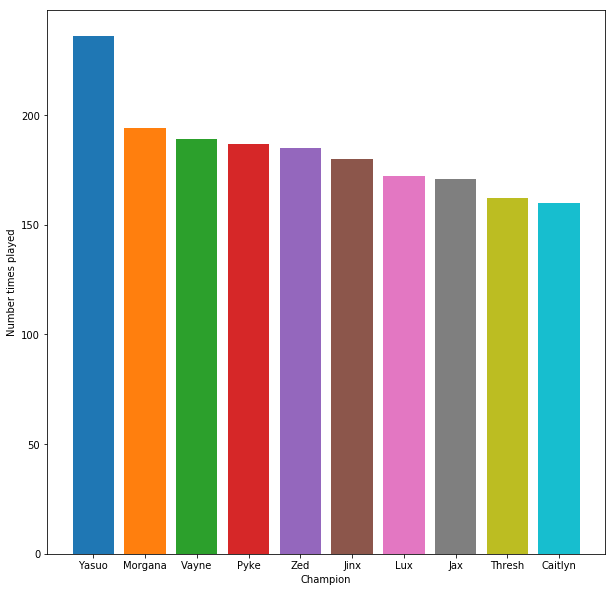

In [95]:
plt.xlabel("Champion")
plt.ylabel("Number times played")

topChamps = 10

x = np.array([i+1 for i in range(topChamps)])

my_xticks = [idchampions[str(champsFiltered[i][0])] for i in range(topChamps)]
plt.xticks(x, my_xticks)

for i in range(topChamps):
  plt.bar(i+1, champsFiltered[i][1], width=0.8, align='center' )

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] =10
fig_size[1] =10
plt.rcParams["figure.figsize"] = fig_size
plt.show()

In [12]:
nonPlayed = []
allPlayed = [idc[0] for idc in champsFiltered]
for id in idchampions.keys() :
  if int(id) not in allPlayed :
    nonPlayed.append(idchampions[id])
    
print("Non-played champions:\n")
nonPlayed

Non-played champions:



[]

##Get champions with most and less winrate

In [0]:
numberGamesPerChamp = dict(champsFiltered)

In [0]:
championWins = []
championLoses = []

for row in game.select("teams", "participants").collect() :
  teamwin = 0
  teamlose = 0
  for team in row['teams']: #2 iterations
    if(team['win'] == 'Win'):
      teamwin = team['teamId']
    else :
      teamlose = team['teamId']
      
  for participant in row['participants']: #10 iterations
    if(participant['teamId'] == teamwin):
      championWins.append(participant['championId'])
    else:
      championLoses.append(participant['championId'])


In [0]:
winsFiltred = sc.parallelize(championWins).map(lambda word: (word, 1/numberGamesPerChamp[int(word)])).reduceByKey(lambda a,b:a +b).sortBy(lambda x:x[1], ascending=False).collect()
losesFiltred = sc.parallelize(championLoses).map(lambda word: (word, 1/numberGamesPerChamp[int(word)])).reduceByKey(lambda a,b:a +b).sortBy(lambda x:x[1], ascending=False).collect()

In [0]:
mostWinChamp = idchampions[str(winsFiltred[0][0])]
mostLosesChamp = idchampions[str(losesFiltred[0][0])]

winrate = "{0:.2f}".format(winsFiltred[0][1] * 100)
lossrate = "{0:.2f}".format(losesFiltred[0][1] * 100) 

In [23]:

print("Most winrate:   " + mostWinChamp + " " + str(winrate) + "% winrate")
print("Most loss rate: " + mostLosesChamp + " " + str(lossrate) + "% loss rate")

Most winrate:   Sona 66.67% winrate
Most loss rate: Alistar 75.41% loss rate


In [30]:
for i in range(len(winsFiltred)):
  wRateChamp = idchampions[str(winsFiltred[i][0])]
  wRateValue = "{0:.2f}".format(winsFiltred[i][1] * 100)
  print(wRateChamp + " " + str(wRateValue) + "% winrate")

Sona 66.67% winrate
Rumble 66.67% winrate
Singed 66.67% winrate
Tristana 65.89% winrate
Ivern 64.29% winrate
Sejuani 64.00% winrate
Riven 63.73% winrate
Bard 63.04% winrate
Yorick 61.54% winrate
Quinn 61.36% winrate
Kalista 61.11% winrate
Ziggs 61.11% winrate
Nami 60.00% winrate
Taric 60.00% winrate
Gragas 60.00% winrate
Ekko 59.62% winrate
Varus 59.52% winrate
Brand 59.34% winrate
Talon 58.97% winrate
Tryndamere 58.93% winrate
Zed 58.92% winrate
TahmKench 58.70% winrate
Lissandra 58.33% winrate
Shen 58.06% winrate
Janna 58.00% winrate
Olaf 57.78% winrate
Xerath 57.69% winrate
Garen 57.61% winrate
Ashe 57.43% winrate
Heimerdinger 57.14% winrate
Corki 56.67% winrate
Nunu 56.67% winrate
Pantheon 56.52% winrate
Nidalee 56.25% winrate
Gnar 55.88% winrate
Amumu 55.56% winrate
Jinx 55.56% winrate
Sivir 55.42% winrate
Kayn 55.40% winrate
DrMundo 55.06% winrate
Fiora 54.55% winrate
Jax 54.39% winrate
Draven 54.35% winrate
Mordekaiser 54.29% winrate
Khazix 54.22% winrate
Nautilus 53.85% winrate

##Get champion that killed most and died most

In [0]:
killperchamp = [(df['championId'],int(df['stats']['kills'])) for row in game.select("participants").collect() for df in row['participants']]
deathsperchamp = [(df['championId'],int(df['stats']['deaths'])) for row in game.select("participants").collect() for df in row['participants']]  

In [0]:
killperchampFiltered = sc.parallelize(killperchamp).reduceByKey(lambda a,b:a +b).sortBy(lambda x:x[1], ascending=False).collect()
deathsperchampFiltered = sc.parallelize(deathsperchamp).reduceByKey(lambda a,b:a +b).sortBy(lambda x:x[1], ascending=False).collect()

In [22]:
print("Champion with more kills  -  " + idchampions[str(killperchampFiltered[0][0])] + " " + str(killperchampFiltered[0][1]) + " kills " + "{0:.2f}".format(int(killperchampFiltered[0][1])/numberGamesPerChamp[killperchampFiltered[0][0]]) + " kill/game (" + str(numberGamesPerChamp[killperchampFiltered[0][0]])  + " games)")
print("Champion with more deaths -  " + idchampions[str(deathsperchampFiltered[0][0])] + " " + str(deathsperchampFiltered[0][1]) + " deaths " + "{0:.2f}".format(int(deathsperchampFiltered[0][1])/numberGamesPerChamp[deathsperchampFiltered[0][0]]) + " death/game (" + str(numberGamesPerChamp[deathsperchampFiltered[0][0]])  + " games)")



Champion with more kills  -  Zed 1764 kills 9.54 kill/game (185 games)
Champion with more deaths -  Yasuo 1743 deaths 7.39 death/game (236 games)


##Team color with most winrate

In [0]:
blueWinRates = 0
for gamesito in game.select('teams').collect():
  if(gamesito['teams'][0]['win'] == 'Win'):
    blueWinRates += 1


In [25]:
print("Blue side winrate: " + str(blueWinRates) + " wins - " + "{0:.2f}".format(blueWinRates*100/game.count()) + "%") 
print("Red side winrate:  " + str(game.count() - blueWinRates) + " wins - " + "{0:.2f}".format((game.count() - blueWinRates)*100/game.count())  + "%")

Blue side winrate: 486 wins - 51.37%
Red side winrate:  460 wins - 48.63%


##Top champs with most first kill

In [0]:
firstBloodChamps = []

for part in game.select(explode('participants')).collect():
   if(part['col']['stats']['firstBloodKill']):
    firstBloodChamps.append(part['col']['championId'])


In [0]:
firstBloodTop = sc.parallelize(firstBloodChamps).map(lambda word: (word, 1)).reduceByKey(lambda a,b:a +b).sortBy(lambda x:x[1], ascending=False).collect()

No handles with labels found to put in legend.


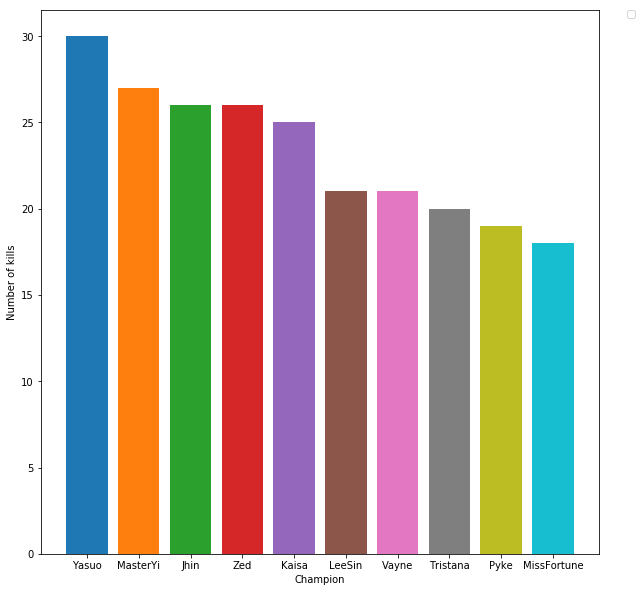

In [49]:
plt.xlabel("Champion")
plt.ylabel("Number of kills")

topChamps = 10

x = np.array([i+1 for i in range(topChamps)])

my_xticks = [idchampions[str(firstBloodTop[i][0])] for i in range(topChamps)]
plt.xticks(x, my_xticks)

for i in range(topChamps):
  plt.bar(i+1, firstBloodTop[i][1], width=0.8, align='center' )

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] =5
fig_size[1] =10
plt.rcParams["figure.figsize"] = fig_size
plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0)
plt.show()

In [28]:
for i in range(len(firstBloodTop)):
  print("Top " + str(i+1) + ": " + idchampions[str(firstBloodTop[i][0])] + " with " + str(firstBloodTop[i][1]))


Top 1: Yasuo with 30
Top 2: MasterYi with 27
Top 3: Jhin with 26
Top 4: Zed with 26
Top 5: Kaisa with 25
Top 6: LeeSin with 21
Top 7: Vayne with 21
Top 8: Tristana with 20
Top 9: Pyke with 19
Top 10: MissFortune with 18
Top 11: Caitlyn with 18
Top 12: Twitch with 17
Top 13: Lux with 17
Top 14: Akali with 16
Top 15: Jax with 16
Top 16: Morgana with 16
Top 17: Irelia with 16
Top 18: Jinx with 15
Top 19: Riven with 15
Top 20: Darius with 15
Top 21: Draven with 14
Top 22: Ezreal with 14
Top 23: Quinn with 13
Top 24: Khazix with 12
Top 25: Ashe with 11
Top 26: Katarina with 11
Top 27: Vi with 10
Top 28: Kayn with 10
Top 29: Rengar with 10
Top 30: JarvanIV with 10
Top 31: Lucian with 9
Top 32: Neeko with 9
Top 33: DrMundo with 9
Top 34: Kayle with 9
Top 35: Xerath with 9
Top 36: Tryndamere with 9
Top 37: Teemo with 9
Top 38: Sivir with 9
Top 39: Veigar with 9
Top 40: Hecarim with 8
Top 41: Thresh with 8
Top 42: Olaf with 8
Top 43: Blitzcrank with 8
Top 44: Garen with 7
Top 45: Pantheon with 

##When there are more games played

In [0]:
from datetime import datetime
import time

In [85]:
datesCount = {}
datesCount['mati'] = 0
datesCount['migdia'] = 0
datesCount['tarda'] = 0
datesCount['nit'] = 0

#8 - 12 matí 
#13 - 15 migdia
#16 - 21 tarda
#22 - 7 nit

for row in game.select("gameCreation").collect():
  date = datetime.fromtimestamp(row['gameCreation']/1000.0)
  print(date.strftime('%Y-%m-%d %H:%M:%S'))
  h = date.hour
  if(h>= 8 and h<= 12):
    datesCount['mati'] = datesCount['mati'] + 1
  elif(h>=13 and h<=15):
    datesCount['migdia'] = datesCount['migdia'] + 1
  elif(h>=16 and h <=21):
    datesCount['tarda'] = datesCount['tarda'] + 1
  else:
    datesCount['nit'] = datesCount['nit'] + 1
  

    

2019-04-04 14:45:52
2019-04-04 14:45:11
2019-04-04 14:44:49
2019-04-04 14:45:27
2019-04-04 14:45:10
2019-04-04 14:43:21
2019-04-04 14:45:24
2019-04-04 14:44:44
2019-04-04 14:45:26
2019-04-04 14:45:36
2019-04-04 14:45:00
2019-04-04 14:45:39
2019-04-04 14:45:50
2019-04-04 14:43:22
2019-04-04 14:42:55
2019-04-04 14:45:01
2019-04-04 14:45:23
2019-04-04 14:45:00
2019-04-04 14:45:06
2019-04-04 14:43:43
2019-04-04 14:45:17
2019-04-04 14:45:05
2019-04-04 14:45:08
2019-04-04 14:45:34
2019-04-04 14:44:27
2019-04-04 14:44:59
2019-04-04 14:44:24
2019-04-04 14:45:25
2019-04-04 14:45:19
2019-04-04 14:45:06
2019-04-04 14:44:37
2019-04-04 14:44:44
2019-04-04 14:45:07
2019-04-04 14:45:17
2019-04-04 14:45:41
2019-04-04 14:44:57
2019-04-04 14:45:42
2019-04-04 14:45:39
2019-04-04 14:45:32
2019-04-04 14:45:08
2019-04-04 14:45:13
2019-04-04 14:45:32
2019-04-04 14:43:29
2019-04-04 14:44:57
2019-04-04 14:44:40
2019-04-04 14:45:02
2019-04-04 14:43:32
2019-04-04 14:44:54
2019-04-04 14:44:10
2019-04-04 14:43:19


In [81]:
game.count()

946

##Get champions with best and worst average of creep/s

In [103]:
summonersRiftGames = game
summonersRiftGames.show(1)

champsIds = summonersRiftGames.select(explode('participants.championId').alias('ChampionId'))
creepsPerChamps = summonersRiftGames.select(explode('participants.stats.neutralMinionsKilled').alias('Creeps'))
jngleEnemyPerChamps = summonersRiftGames.select(explode('participants.stats.neutralMinionsKilledEnemyJungle').alias('EnJngle'))
jngleAllyPerChamps = summonersRiftGames.select(explode('participants.stats.neutralMinionsKilledTeamJungle').alias('AllyJngle'))

+-------------+------------+----------+--------------------+--------------------+
| gameCreation|gameDuration|    gameId|        participants|               teams|
+-------------+------------+----------+--------------------+--------------------+
|1554389152476|        2101|3984697779|[[25, SILVER, 1, ...|[[[[10, 1], [35, ...|
+-------------+------------+----------+--------------------+--------------------+
only showing top 1 row



In [104]:
from pyspark.sql.functions import monotonically_increasing_id, asc, desc

creepsPerChamps = creepsPerChamps.withColumn("id", monotonically_increasing_id())

jngleEnemyPerChamps = jngleEnemyPerChamps.withColumn("id", monotonically_increasing_id())

jngleAllyPerChamps = jngleAllyPerChamps.withColumn("id", monotonically_increasing_id())

tmpDF = creepsPerChamps.join(jngleEnemyPerChamps, "id","full")
creepsDF = tmpDF.join(jngleAllyPerChamps, "id","full")
creepsDF = creepsDF.sort(asc("id")).drop("id")

totalCreeps = creepsDF.withColumn('GameCreeps', sum(creepsDF[col] for col in creepsDF.columns))
totalCreeps = totalCreeps.drop("Creeps")
totalCreeps = totalCreeps.drop("EnJngle")
totalCreeps = totalCreeps.drop("AllyJngle")

totalCreeps = totalCreeps.withColumn("id", monotonically_increasing_id())
champsIds = champsIds.sort(asc("ChampionId"))
champs = champsIds.withColumn("id", monotonically_increasing_id())

champCreeps = champs.join(totalCreeps, "id")
champCreeps = champCreeps.drop("id").sort(asc("ChampionId"))
champCreeps.show(10)

+----------+----------+
|ChampionId|GameCreeps|
+----------+----------+
|         1|       148|
|         1|         5|
|         1|         0|
|         1|         0|
|         1|        24|
|         1|         0|
|         1|         0|
|         1|         0|
|         1|         0|
|         1|         0|
+----------+----------+
only showing top 10 rows



In [0]:
champCreepsDict = {}
maxValue = 0
minValue = 1000
minId = 0
maxId= 0
for row in champCreeps.rdd.collect():
  if not row['ChampionId'] in champCreepsDict:
    champID = row['ChampionId']
    champCreepsDict[champID] = (row['GameCreeps'],1)
  else:
    champID = row['ChampionId']
    creeps = row['GameCreeps']
    creeps = creeps + champCreepsDict.get(row['ChampionId'])[0]
    counter = champCreepsDict.get(row['ChampionId'])[1] + 1
    champCreepsDict[champID] = (creeps,counter)
    
for key in champCreepsDict:
  tupla = champCreepsDict[key]
  value = tupla[0] / tupla[1]
  if(value > maxValue):
    maxValue = value
    maxId = key
  elif(value < minValue):
    minValue = value
    minId = key
  champCreepsDict[key] = value
  

In [106]:
print("Champion with most avg creeps per games is: " + idchampions[str(maxId)] + " with " + str(maxValue) + " creeps per game")
print("Champion with less avg creeps per games is: " + idchampions[str(minId)] + " with " + str(minValue) + " creeps per game")

Champion with most avg creeps per games is: Zed with 68.95652173913044 creeps per game
Champion with less avg creeps per games is: Zac with 18.666666666666668 creeps per game
